In [1]:
# https://www.kaggle.com/datasets/ahmedshahriarsakib/uber-eats-usa-restaurants-menus?select=restaurant-menus.csv
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from IPython.display import display
from ipywidgets import Checkbox

from sklearn.impute import SimpleImputer
from ipywidgets import widgets
import os
from IPython.display import clear_output


In [120]:
def PrzetworzKategorie(df):
    # nazwy kategorii restauracji zmniejszam do małych liter, oraz rozdzielam do nowych kolumn o nazwach od 0 - 29
    df=df.join(df['category'].str.lower().str.split(',', expand=True))

    df.drop('category', axis=1, inplace=True)

#Tworze kolumny dla każdej osobnej kategorii restauracji
    df_cat_rest=pd.get_dummies(df, drop_first = False, columns= [x for x in range(0,30)], prefix_sep='', prefix='' )


#Sumuje kategorie które dublują się . Nazwy kategorii są w kolumnach o numerach od 8
    df_sum_cat = df_cat_rest.iloc[:,8:].groupby(df_cat_rest.columns[8:], axis=1).sum()
#do tabeli z informacjami o tabeli 
    df_new_rest=df_cat_rest.iloc[:,:8].join(df_sum_cat)
    return df_new_rest

def filter_restaurants(df, prices=[0,1,2,3,4], score_min=0, position_max=1000):
    con1=df['position']<=position_max 
    con2=df['score']>=score_min 
    con3= df['price'].isin(prices)
    return df[ con1 & con2 & con3]


def reduce_cat(df_cat, oldName, oriName):
    try:
        df_cat.loc[oriName,'sum']=df_cat.loc[oldName, 'sum'] + df_cat.loc[oriName, 'sum']
        df_cat.drop([oldName], axis=0, inplace=True)
    except:
        pass
    return df_cat


def create_cat_table(df_sum_cat):
    df_new_sum =df_sum_cat.sum(axis=0).reset_index()
    df_new_sum.columns=['category', 'sum']
    df_cat=df_new_sum.sort_values('sum', ascending= False).set_index('category')
    df_cat.drop(df_cat[df_cat['sum']<1].index, inplace= True)

    reducedNames = { ' sandwiches': ' sandwich', ' family meals': ' family friendly', ' personal care': ' home &amp; personal care', 'everyday essentials': ' everyday essentials' }
    for newN, oldN in reducedNames.items():
        df_cat = reduce_cat(df_cat, oldN, newN)

    try:
        df_cat.drop('american', axis=0, inplace=True)
 
    except:
        pass
    df_cat = df_cat.iloc[:8,:].sort_values('sum', ascending= False)
    df_cat['percent (%)']= df_cat['sum']/ df_cat['sum'].sum()* 100
    df_cat['percent (%)'] = np.around(df_cat['percent (%)'], decimals=1)
    return df_cat




In [3]:
df_menu=pd.read_csv('restauracje/restaurant-menus.csv')

df_restaurant=pd.read_csv('restauracje/restaurants.csv')


In [ ]:
df_restaurant = df_restaurant.drop(['full_address', 'zip_code'], axis=1)

df_restaurant['price'] = df_restaurant["price_range"].map({None : 0, "$" : 1, "$$" : 2,"$$$" : 3, "$$$$" : 4})
df_restaurant = df_restaurant.drop(['price_range'], axis=1)


df_restaurant['price'].value_counts()


In [110]:
df_restaurant.isnull().sum()/df_restaurant.count()

id          0.000000
position    0.000000
name        0.000000
score       0.807630
ratings     0.807630
category    0.000572
lat         0.000000
lng         0.000000
price       0.197910
dtype: float64

<bound method NDFrame._add_numeric_operations.<locals>.mean of 0        NaN
1        NaN
2        NaN
3        NaN
4        4.7
        ... 
40222    4.8
40223    4.6
40224    4.7
40225    4.7
40226    4.4
Name: score, Length: 40227, dtype: float64>

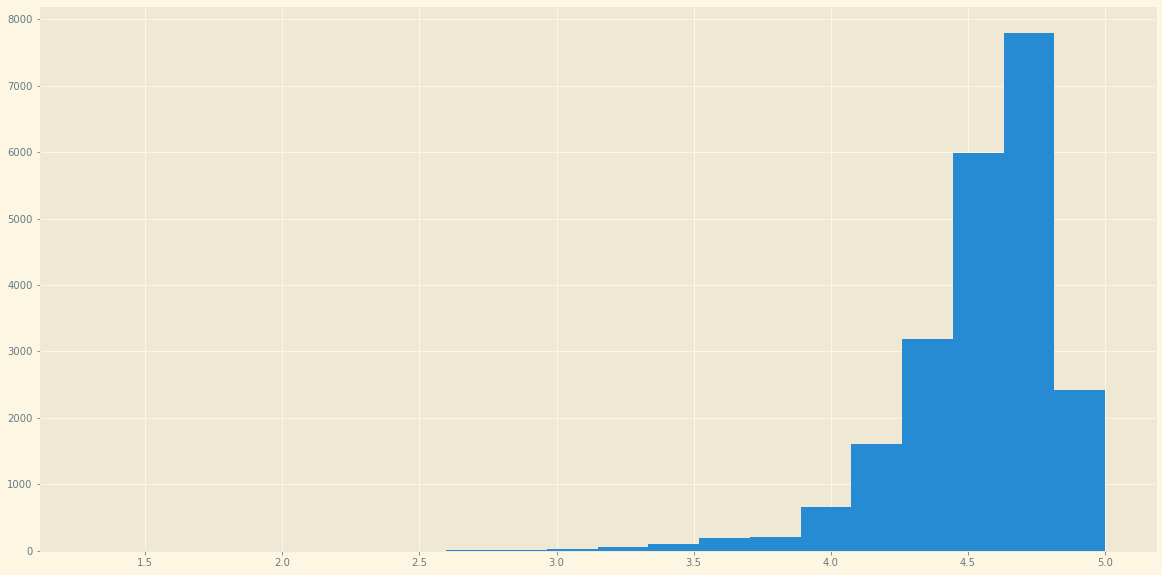

In [113]:
plt.hist(df_restaurant.score, bins=20)


In [117]:
df_restaurant.score.mean()
df_restaurant.score.median()

4.5609957760403095

In [6]:
df_new_rest=PrzetworzKategorie(df_restaurant)

df_new_rest.head()


,id,position,name,score,ratings,lat,lng,price,aapi-owned,adult,...,vegetarian / vegan,vegetarian friendly,vegetarian-friendly,venezuelan,vietnamese,western,western-style japanese food,wine,wings,women-owned
0,1,19,PJ Fresh (224 Daniel Payne Drive),NaN,NaN,33.562365,-86.830703,1.0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,9,J' ti`'z Smoothie-N-Coffee Bar,NaN,NaN,33.583640,-86.773330,NaN,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,6,Philly Fresh Cheesesteaks (541-B Graymont Ave),NaN,NaN,33.509800,-86.854640,1.0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,17,Papa Murphy's (1580 Montgomery Highway),NaN,NaN,33.404439,-86.806614,1.0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,162,Nelson Brothers Cafe (17th St N),4.7,22.0,33.514730,-86.811700,NaN,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:

df_full_rest = df_new_rest.copy()
mean_imputer = SimpleImputer(strategy='mean')
median_imputer = SimpleImputer(strategy='median')
df_full_rest['price'] = median_imputer.fit_transform(df_full_rest['price'].values.reshape(-1,1))
df_full_rest['score'] = mean_imputer.fit_transform(df_full_rest['score'].values.reshape(-1,1))

df_full_rest.head()

df_new_rest=df_full_rest

(40227, 559)

In [ ]:
boxP0 = Checkbox(False, description='Price 0')
boxP1= Checkbox(False, description='Price 1')
boxP2 = Checkbox(False, description='Price 2')
boxP3 = Checkbox(False, description='Price 3')
boxP4 = Checkbox(False, description='Price 4')

###RangeSlider
min_score = widgets.FloatSlider(
    value=2.0,
    min=1.0,
    max=5.0,
    step=0.1,
    description='Minimalna ocena:',
    continuous_update=False
)
max_pos = widgets.IntSlider(
    value=3,
    min=1.0,
    max=100,
    step=1.0,
    description='Maksymalna pozycja w wyszukiwarce:',
    continuous_update=False
)


container = widgets.HBox(children=[boxP0, boxP1, boxP2, boxP3,boxP4 ])
container2 = widgets.HBox(children=[min_score, max_pos ])
display(container, alignment=False)
display(container2, alignment=False)
def changed(b):
    clear_output()
    display(container, alignment=False)
    display(container2, alignment=False)
    df_filtered= filter_restaurants(df_new_rest, position_max=max_pos.value, prices =[ i for i, value in enumerate([boxP0.value, boxP1.value, boxP2.value, boxP3.value, boxP4.value]) if value == True], score_min=min_score.value)

#Wypisuje najlepsze restauracje ( 10 najlepszych) sortując po position malejąco, score rosnąco, ratings rosnąco
    a=df_filtered.sort_values(['position', 'score', 'ratings'], ascending= [True, False, False]).head(10)
    display(a)

boxP0.observe(changed,names="value")
boxP1.observe(changed,names="value")
boxP2.observe(changed,names="value")
boxP3.observe(changed,names="value")
boxP4.observe(changed,names="value")
max_pos.observe(changed,names="value")
min_score.observe(changed,names="value")



,id,position,name,score,ratings,lat,lng,price,aapi-owned,adult,...,vegetarian / vegan,vegetarian friendly,vegetarian-friendly,venezuelan,vietnamese,western,western-style japanese food,wine,wings,women-owned
17589,17590,2,Yama Sushi Roll House (Yorktown),4.700000,79.0,37.114063,-76.463396,4.0,0,0,...,0,0,0,0,0,0,0,0,0,0
21261,21262,3,Yiannis (401 N Great Neck Rd),4.560996,NaN,36.845680,-76.048420,4.0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
df_new_rest.head()

,id,position,name,score,ratings,lat,lng,price,aapi-owned,adult,...,vegetarian / vegan,vegetarian friendly,vegetarian-friendly,venezuelan,vietnamese,western,western-style japanese food,wine,wings,women-owned
0,1,19,PJ Fresh (224 Daniel Payne Drive),4.560996,NaN,33.562365,-86.830703,1.0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,9,J' ti`'z Smoothie-N-Coffee Bar,4.560996,NaN,33.583640,-86.773330,1.0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,6,Philly Fresh Cheesesteaks (541-B Graymont Ave),4.560996,NaN,33.509800,-86.854640,1.0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,17,Papa Murphy's (1580 Montgomery Highway),4.560996,NaN,33.404439,-86.806614,1.0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,162,Nelson Brothers Cafe (17th St N),4.700000,22.0,33.514730,-86.811700,1.0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
df_new_sum =df_new_rest.iloc[:,8:].sum(axis=0).reset_index()
df_new_sum.columns=['category', 'sum']
df_new_sum.head()
df_cat=df_new_sum.sort_values('sum', ascending= False).set_index('category')
df_cat.head(-5)

,sum
category,
american,10008
american,7875
fast food,4608
burgers,4235
sandwiches,4208
...,...
aapi-owned,1
ameican,1
american (new),1


In [103]:

df_cat=df_new_sum.sort_values('sum', ascending= False).set_index('category')
df_cat.drop(df_cat[df_cat['sum']<1].index, inplace= True)


try:
    df_cat.drop('american', axis=0, inplace=True)
except:
    pass

try:
    df_cat.loc[' sandwiches','sum']=df_cat.loc[' sandwiches','sum'] + df_cat[' sandwich','sum']
    df_cat.drop(' sandwich', axis=0, inplace=True)
except:
    pass

try:
    df_cat['personal care'] = df_cat['home &amp; personal care']
    df_cat.drop('home &amp; personal care', axis=0, inplace=True)
except:
    pass

df_cat = df_cat.iloc[:8,:]
df_cat['percent (%)']= df_cat['sum']/ df_cat['sum'].sum()* 100
np.sum(df_cat['percent (%)'])

df_cat.drop([' sandwich'], axis=0, inplace=True)
df_cat


,sum,percent (%)
category,,
american,10008,25.930820
fast food,4608,11.939370
burgers,4235,10.972924
sandwiches,4208,10.902967
family meals,4066,10.535043
healthy,3782,9.799197
comfort food,3565,9.236948


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


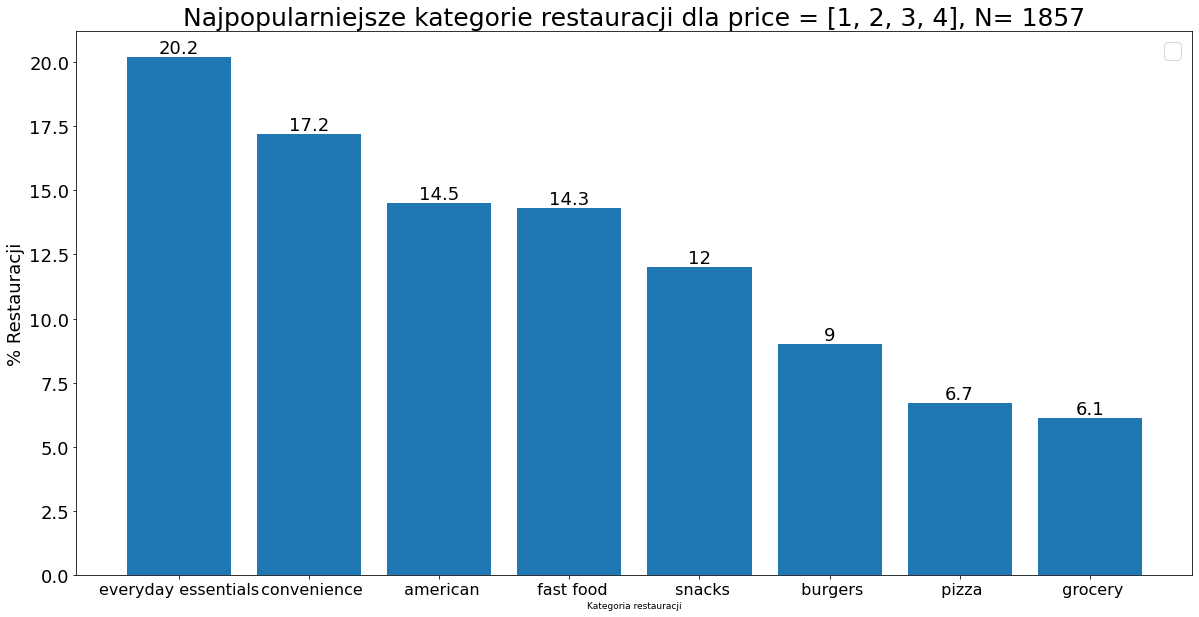

 Ilosc restauracji: 1857


,sum,percent (%)
category,,
everyday essentials,375,20.2
convenience,319,17.2
american,269,14.5
fast food,265,14.3
snacks,223,12.0
burgers,167,9.0
pizza,125,6.7
grocery,114,6.1


In [ ]:
boxP1= Checkbox(False, description='Price 1')
boxP2 = Checkbox(False, description='Price 2')
boxP3 = Checkbox(False, description='Price 3')
boxP4 = Checkbox(False, description='Price 4')

###RangeSlider
min_score = widgets.FloatSlider(
    value=1.0,
    min=1.0,
    max=5.0,
    step=0.1,
    description='Min. rate:',
    continuous_update=False
)
max_pos = widgets.IntSlider(
    value=300,
    min=1.0,
    max=300,
    step=1.0,
    description='Max pos:',
    continuous_update=False
)


container = widgets.HBox(children=[boxP1, boxP2, boxP3,boxP4 ])
container2 = widgets.HBox(children=[min_score, max_pos ])
display(container, alignment=False)
display(container2, alignment=False)
def changed(b):
    clear_output()
    display(container, alignment=False)
    display(container2, alignment=False)
    df_filtered= filter_restaurants(df_new_rest, position_max=max_pos.value, prices =[ i for i, value in enumerate([0, boxP1.value, boxP2.value, boxP3.value, boxP4.value]) if value == True], score_min=min_score.value)
    cat_table =create_cat_table(df_filtered.iloc[:,8:])


    prices = [ i for i, value in enumerate([False, boxP1.value, boxP2.value, boxP3.value, boxP4.value]) if value == True]


    fig, ax = plt.subplots()
    bars = ax.bar(cat_table.iloc[:8, -1].index, cat_table.iloc[:8, -1].values)

    ax.bar_label(bars)

    ax.legend(loc='best', fontsize=22)
    plt.rcParams["figure.figsize"] = (20,10)
    N=cat_table['sum'].sum()
    plt.rcParams['font.size'] = 18
    ax.set_xlabel('Kategoria restauracji', fontsize=9)
    ax.set_ylabel('% Restauracji', fontsize=18)
    ax.set_title(f'Najpopularniejsze kategorie restauracji dla price = {prices}, N= {N}', fontsize=25)
    plt.xticks(fontsize=16)
    plt.show()
    print(f" Ilosc restauracji: {cat_table['sum'].sum()}")
    display(cat_table.head(10))

boxP1.observe(changed,names="value")
boxP2.observe(changed,names="value")
boxP3.observe(changed,names="value")
boxP4.observe(changed,names="value")
max_pos.observe(changed,names="value")
min_score.observe(changed,names="value")




In [399]:
# Badanie popularności kategorii dań w restauracjach

df_menu.groupby('category').count().sort_values(['restaurant_id'], ascending=False).head(5)
#df_pop_menu

,restaurant_id,name,description,price
category,,,,
Picked for you,145401,145401,119673,145401
Beverages,103391,103391,47436,103391
Sandwiches,102730,102730,98714,102730
Sides,93354,93354,46435,93354
Drinks,85904,85904,41634,85904


In [401]:
min_price=1
max_price=4

df_rest_pric=df_restaurant[(df_restaurant['price']>=min_price) & (df_restaurant['price']<=max_price)]
df_rest_merge = pd.merge(df_rest_pric, df_menu, left_on='id', right_on='restaurant_id', how='left')


In [404]:
df_rest_merge

,id,position,name_x,score,ratings,category_x,lat,lng,price_x,restaurant_id,category_y,name_y,description,price_y
0,1,19,PJ Fresh (224 Daniel Payne Drive),NaN,NaN,"Burgers, American, Sandwiches",33.562365,-86.830703,1.0,1.0,Extra Large Pizza,Extra Large Meat Lovers,Whole pie.,15.99 USD
1,1,19,PJ Fresh (224 Daniel Payne Drive),NaN,NaN,"Burgers, American, Sandwiches",33.562365,-86.830703,1.0,1.0,Extra Large Pizza,Extra Large Supreme,Whole pie.,15.99 USD
2,1,19,PJ Fresh (224 Daniel Payne Drive),NaN,NaN,"Burgers, American, Sandwiches",33.562365,-86.830703,1.0,1.0,Extra Large Pizza,Extra Large Pepperoni,Whole pie.,14.99 USD
3,1,19,PJ Fresh (224 Daniel Payne Drive),NaN,NaN,"Burgers, American, Sandwiches",33.562365,-86.830703,1.0,1.0,Extra Large Pizza,Extra Large BBQ Chicken &amp; Bacon,Whole Pie,15.99 USD
4,1,19,PJ Fresh (224 Daniel Payne Drive),NaN,NaN,"Burgers, American, Sandwiches",33.562365,-86.830703,1.0,1.0,Extra Large Pizza,Extra Large 5 Cheese,Whole pie.,14.99 USD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2988227,40227,50,Beijing Wok,4.4,254.0,"Chinese, Asian, Asian Fusion, Family Friendly,...",30.202210,-97.838689,1.0,40227.0,Kid’s Mains,Lion Plate,BBQ skewer two pices and fantail shrimp two pi...,8.55 USD
2988228,40227,50,Beijing Wok,4.4,254.0,"Chinese, Asian, Asian Fusion, Family Friendly,...",30.202210,-97.838689,1.0,40227.0,Beverages,Soft Drinks,NaN,1.95 USD
2988229,40227,50,Beijing Wok,4.4,254.0,"Chinese, Asian, Asian Fusion, Family Friendly,...",30.202210,-97.838689,1.0,40227.0,Beverages,Iced Tea,NaN,1.95 USD
2988230,40227,50,Beijing Wok,4.4,254.0,"Chinese, Asian, Asian Fusion, Family Friendly,...",30.202210,-97.838689,1.0,40227.0,Desserts,Sesame Balls (4 pcs),NaN,3.95 USD
